Modelo inicial de resistividades verdaderas donde tenemos 25 capas. Donde la última corresponde al semiespacio.


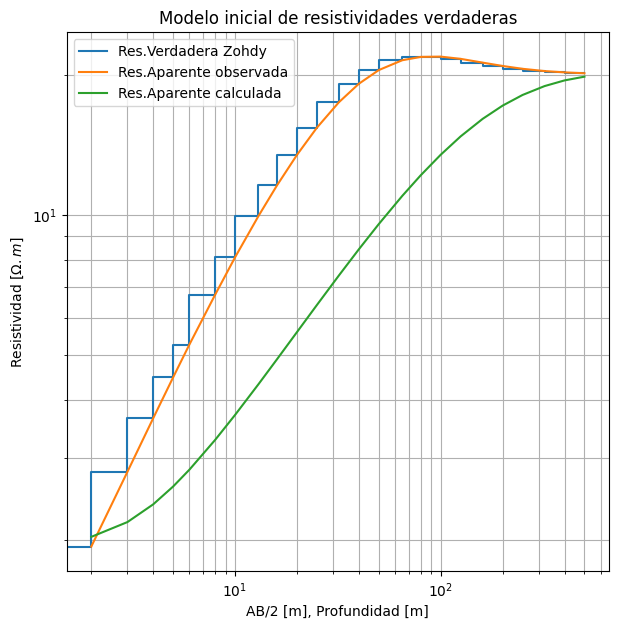

Ajusto espesores hasta poner en fase la resistividad observada y la resistividad aparente dada por el modelo.


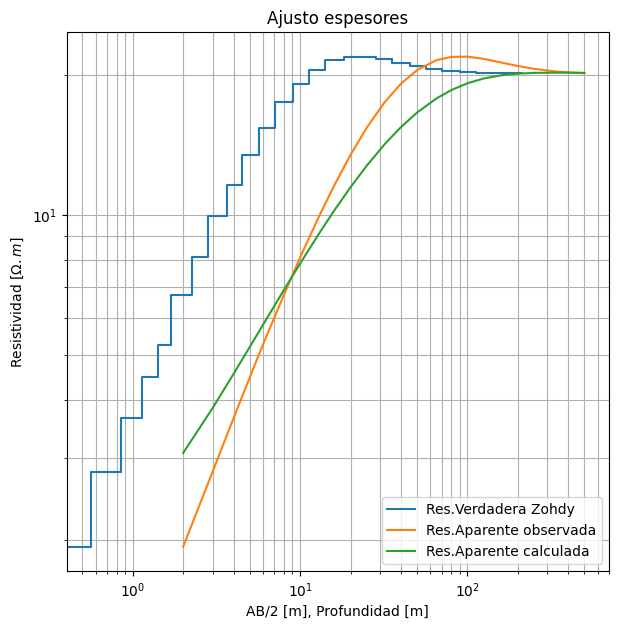

Ajusto resistividades verdaderas hasta que se aproximen la resistividad aparente observada y calculada.


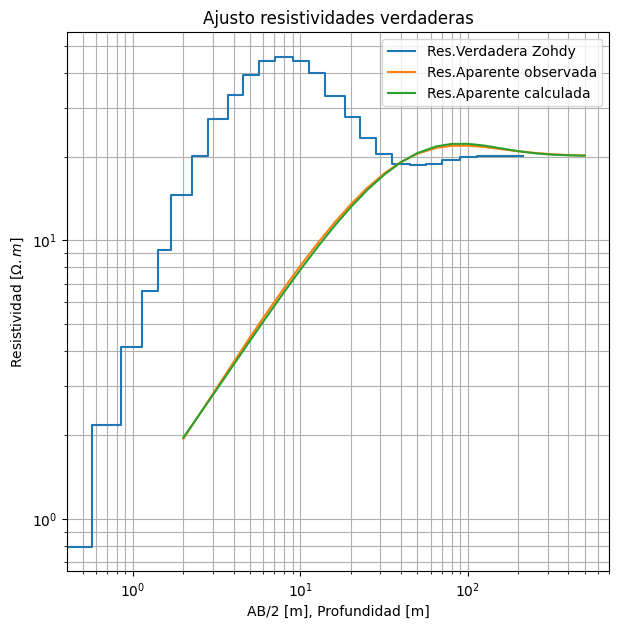

Busco las capas equivalentes y calculo la resistividad aparente. Probablemente se desajuste nuevamente la resistividad aparente observada y calculada.


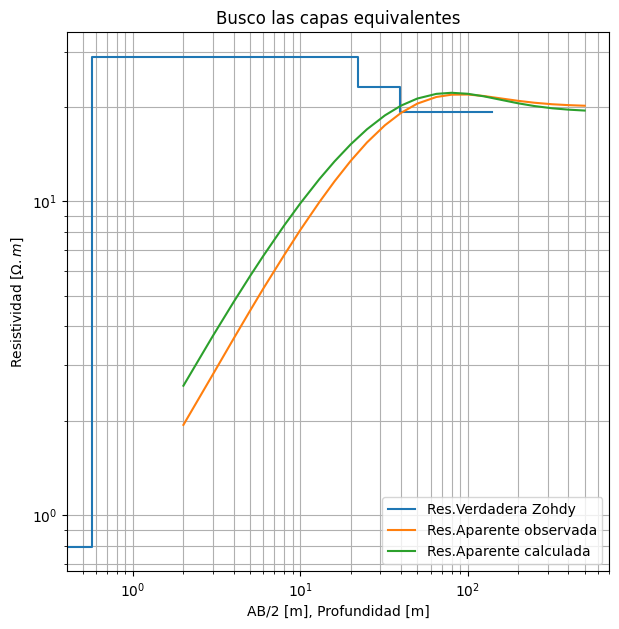

Resistividad aparente observada y calculada a partir del modelo luego de aplicar un ajuste manual


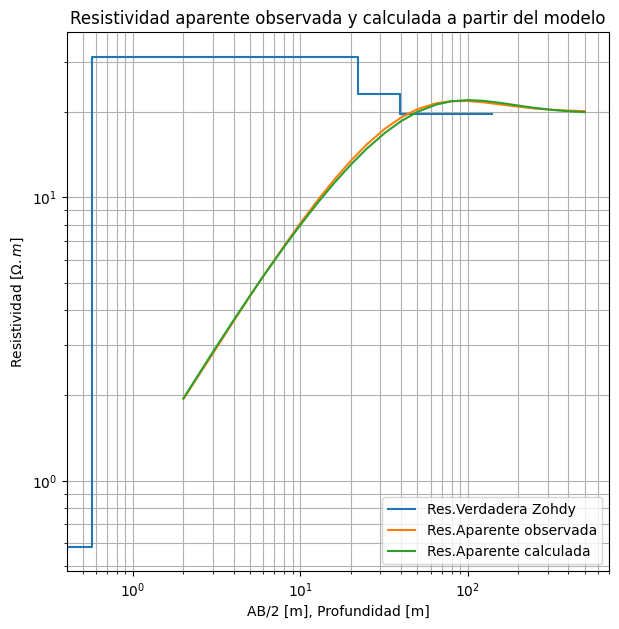

Finalmente:
Resistividad del modelo propuesto: [ 0.58457688 31.40285905 23.08841322 19.72922656]
Espesores del modelo propuesto: [ 0.56485907 21.67037605 17.06912957]
RMS del modelo: 1.692199834835163


In [1]:
###########################################################################
#             ALGORITMO DE ZHODY
#
#Los valores de AB/2 se cargan en el vector 'absisas' y de Resistividades observada en 'rho_ap'. Estos se encuentran en la sección
#MAIN al final del codigo.
#El paso a paso de como utilizar el codigo se encuentra en la parte de MAIN.
#Se recomienda solo modificar la parte de MAIN para ajustar las curvas y encontrar la resistividad verdadera.
#
#Código: Facundo Barrera,2024.
###########################################################################

import numpy as np
import matplotlib.pyplot as plt

def calculo_res_apa(absisas,rho,esp):
  N=len(rho)#Defino el número de capas
  lamb_inv=np.ones(20)#Aquí se pondrá los valores del eje de las absisas, que se corresponden con la inversa de lambada
  q=0
  T=np.ones((len(absisas),20))#T será la transformada de la resistividad utilizada para para el cálculo de la resistividad aparente en cada valor de absisa
  lamb_inv_g=np.ones((len(absisas),20))

  #Para cada valor de absisa calculo la transformada
  for c in absisas:
    for i in range(-14,6):#para luego aplicar el filro debemos calcular T en 14 puntos equiespaciados en 1/lambda hacia atras de la absisa tomada
                          #y 5 para adelante.
      lamb_inv[i+14]=c*(10**(i/6)) #como se grafica en función de 1/lambda. 1/lambda debe estar esquipaciado visto desde la escala logaritmica
    lamb_inv=lamb_inv*np.exp(-0.13069)
    lamb_inv_g[q,:]=lamb_inv#guardo en la q-esima fila de la matriz lamb_inv_g el valor de los lamb_inv para calcular T en la q-esima absisa
    lamb=1/lamb_inv #calculo lambda
    L=(rho[N-1]-rho[N-2])/(rho[N-1]+rho[N-2]) #Aplico el algoritimo de Sunde
    M=(1+L*np.exp(-2*lamb*esp[N-2]))/(1-L*np.exp(-2*lamb*esp[N-2]))
    for i in np.arange(2,N,1):
      L=(rho[N-i]*M-rho[N-i-1])/(rho[N-i]*M+rho[N-1-i])
      M=(1+L*np.exp(-2*lamb*esp[N-1-i]))/(1-L*np.exp(-2*lamb*esp[N-1-i]))
    T[q,:]=rho[0]*M #Finalmente obtengo T
    q=q+1

  #Defino el filtro de  O’Niell
  filtro=np.array([0.003042,-0.001198,0.01284,0.02350,0.08688,0.2374,0.6194,1.1817,0.4248,-3.4507,2.7044,-1.1324,0.3930,-0.1436,0.05812,-0.02521,0.01125,-0.004978,0.002072,-0.000318])
  rho_ap=np.zeros(len(absisas))#Aquí se va a calcular la resestividad aparente para cada absisa

  for m in range(0,len(absisas)):#calculo por cada absisa la resistividad aparente rho_ap
    rho_ap[m]=np.convolve(filtro,T[m,:])[len(filtro)-1]#me quedo con el valor central, que es cuando todos los valores del filtro se multiplican con sus respectivos valore de T.

  return rho_ap

def creacion_modelo_inicial(absisas):#Creo el modelo inicial de espesores propuesto a partir de la resistividad observada
  N=len(absisas)
  esp_v=np.ones(N-1)*absisas[0]
  for i in range(1,N-1):
      esp_v[i]=absisas[i]-absisas[i-1]#los espesores toman el valor de las diferencias de las absisas.
  return esp_v

def ajusto_espesores(limRMS,espesor_inicial,rho):#Ajusto espesores del modelo propuesto, hasta obtener un RMS < limRMS=2, si se puede
  N=len(rho)
  RMS=1000
  q=1000
  while RMS<=q and RMS>limRMS:
    q=RMS
    rho_ap1=calculo_res_apa(absisas,rho,espesor_inicial)#calculo la resistividad aparente del modelo
    RMS=calculo_rms(rho,rho_ap1)
    esp_v1=espesor_inicial
    espesor_inicial=espesor_inicial*0.9 #ajusto los espesores

  RMS=q
  return esp_v1

def ajusto_res_ver(limRMS,espesor,res_inicial):#Ajusto resistividades verdaderas del modelo propuesto, hasta obtener un RMS < limRMS=2, si se puede
  RMS=1000
  q=1000
  j=0
  res=res_inicial.copy()
  while RMS<=q and RMS>limRMS:
    q=RMS
    res_apa=calculo_res_apa(absisas,res,espesor)
    RMS=calculo_rms(res_inicial,res_apa)
    resfinal=res
    for i in range(0,len(absisas)):
      res[i]=res_inicial[i]*res[i]/res_apa[i]#ajusto resistividades
  return resfinal

def capas_equivalentes(res,esp,sec):
  N=len(sec)
  N1=len(res)
  Raj=np.ones(N-1)
  Eaj=np.ones(N-2)
  S1=esp/res[0:(N1-1)]
  T1=esp*res[0:(N1-1)]
  q=0
  for h in range(0,N-1):
    Sa=0
    Ta=0
    for j in range(sec[h],sec[h+1]):
      Sa=Sa+S1[j]
      Ta=Ta+T1[j]
    Raj[q]=np.sqrt(Ta/Sa)
    if h!=N-2:
        Eaj[q]=np.sqrt(Ta*Sa)
    q=q+1

  return Raj,Eaj

def ajuste_manual(r,ar,e,ae):#Ajuste manual de las resistvidades y espesores
  r=r+ar
  e=e+ae
  return r,e

def calculo_rms(ro,rf):#Calculo del RMS entre la resistividad aparente observada y calculada
  rms=np.sqrt(sum(((ro-rf)/ro)**2)/len(ro))*100
  return rms

def graficar(absisas,rhoi,rhof,r,e,titulo):#grafico las resistividades
  PROF1z,RV1z=calcular_e_r_grafico(r,e) # aca creo los vectores PROF1z,RV1z para que los espesores y las resistividades verdaderas sean graficables.
  plt.figure(1,figsize=(7,7))
  plt.plot(PROF1z,RV1z,label='Res.Verdadera Zohdy')
  plt.plot(absisas,rhoi,label='Res.Aparente observada')
  plt.plot(absisas,rhof,label='Res.Aparente calculada')
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('AB/2 [m], Profundidad [m]')
  plt.ylabel('Resistividad [$\Omega.m$]')
  plt.title(titulo)
  plt.grid(True, which="both", ls="-")
  plt.legend()
  plt.show()

def calcular_e_r_grafico(r,e): # hago que los espesores y las resistividades verdaderas sean graficables.
  profundidades=np.zeros(len(e)*2+2)
  resistividades=np.zeros(len(e)*2+2)
  es=0
  for i in range(0,len(e)):
    es=es+e[i]
    profundidades[i*2+1]=es
    profundidades[i*2+2]=es
    resistividades[i*2]=r[i]
    resistividades[i*2+1]=r[i]
  profundidades[-1]=es+100
  resistividades[-2]=r[-1]
  resistividades[-1]=r[-1]
  return profundidades,resistividades


################################
##########    MAIN    ##########
################################

#Ingresamos el valor de absisas y sus respectivas resistividades aparentes
absisas=np.array([2,3,4,5,6,8,10,13,16,20,25,32,40,50,65,80,100,125,160,200,250,320,400,500])
rho_ap=np.array([1.94,2.81,3.66,4.48,5.27,6.74,8.11,9.95,11.58,13.46,15.4,17.47,19.14,20.48,21.5,21.86,21.89,21.65,21.25,20.90,20.61,20.38,20.25,20.16])

#Calculamos el modelo inicial de espesores
espesor_inicial=creacion_modelo_inicial(absisas)
titulo='Modelo inicial de resistividades verdaderas'
print(titulo,'donde tenemos',len(absisas)+1,'capas. Donde la última corresponde al semiespacio.')
graficar(absisas,rho_ap,calculo_res_apa(absisas,rho_ap,espesor_inicial),rho_ap,espesor_inicial,titulo)

#Ajustamos los espesores, para poner en fase la resistividad aparente calculada y la observada
espesores=ajusto_espesores(2,espesor_inicial,rho_ap)
titulo='Ajusto espesores'
print(titulo,'hasta poner en fase la resistividad observada y la resistividad aparente dada por el modelo.')
graficar(absisas,rho_ap,calculo_res_apa(absisas,rho_ap,espesores),rho_ap,espesores,titulo)

#Ajustamos resestividades verdaderas del modelo
resistividades=ajusto_res_ver(2,espesores,rho_ap)
titulo='Ajusto resistividades verdaderas'
print(titulo,'hasta que se aproximen la resistividad aparente observada y calculada.')
graficar(absisas,rho_ap,calculo_res_apa(absisas,resistividades,espesores),resistividades,espesores, titulo)

#Agrupo por capas equivalentes
sec=np.array([0,1,15,18,len(resistividades)-1])#Aca es importante mantener el 0 y 'len(resistividades)-1'. Cada numero indica entre que numero de capas
                                               #se toman para agrupar.Por ejemplo, sec=np.array([0,1,3,7,8,len(resistividades)-1]), agrupa la primer capa
                                               #por si sola, despues agrupa la (2,3), luego,(4,5,6,7), luego la(8), y despues,
                                               #toma las restantes para calcular una resistividad equivalente pero asignadosela a un semiespacio.
                                               #El ultimo valor puesto ( en este caso el 8 debe ser menor) que la longitud de las absisas menos 1.
r,e=capas_equivalentes(resistividades,espesores,sec)
titulo='Busco las capas equivalentes'
print(titulo,'y calculo la resistividad aparente. Probablemente se desajuste nuevamente la resistividad aparente observada y calculada.')
graficar(absisas,rho_ap,calculo_res_apa(absisas,r,e),r,e,titulo)

#Ajusto manualmente hasta obtener un RMS bajo.
ajuste_r=np.zeros(len(r))
ajuste_e=np.zeros(len(e))#este vector debe tener la misma longitud la cantidad de espesores equivalentes sin contar el semiespacio.
ajuste_r=np.array([-0.21,2.5,0,0.5])#este vector debe tener la misma longitud la cantidad de resistividades equivalentes.
#r[0]=7.65 # puedo asignarle una nueva resistividad
r,e=ajuste_manual(r,ajuste_r,e,ajuste_e)

titulo='Resistividad aparente observada y calculada a partir del modelo'
print(titulo,'luego de aplicar un ajuste manual' )
graficar(absisas,rho_ap,calculo_res_apa(absisas,r,e),r,e,titulo)
RMS=calculo_rms(rho_ap,calculo_res_apa(absisas,r,e))
print('Finalmente:')
print('Resistividad del modelo propuesto:',r)
print('Espesores del modelo propuesto:',e)
print('RMS del modelo:',RMS)